# **A Python Implementation of Sessa Empirical Estimator**  
### *By Jyreneah Angel and Nicole Grace Joligon*
---

## **Abstract**
The Sessa Empirical Estimator (SEE) is a method designed to estimate the duration of medication intervals by analyzing the temporal gaps between consecutive medication fills. This assignment implements SEE using Python, focusing on comparing two clustering approaches: *K-Means* and *DBSCAN*. The study utilizes a simulated dataset to demonstrate the SEE methodology and compares the results generated by the two clustering techniques. The objective is to analyze temporal intervals, filter out long gaps, standardize intervals, and perform clustering to generate insights. The comparison of K-Means and DBSCAN will highlight the strengths and weaknesses of both approaches in estimating medication intervals, providing a comprehensive understanding of their application in the SEE framework.

## **Introduction**

Medication adherence is a crucial factor in healthcare, as consistent and timely medication use significantly impacts treatment outcomes. Gaps between medication fills often serve as a key indicator of potential non-adherence, which can hinder the effectiveness of prescribed treatments. To assess medication intervals more accurately, the **Sessa Empirical Estimator (SEE)** methodology is employed. SEE focuses on identifying patterns in temporal gaps between consecutive medication fills, using clustering techniques to better understand medication regimens and patient compliance.

This study aims to implement the SEE method in Python and apply two clustering algorithms—**K-Means** and **DBSCAN**—to analyze temporal gaps within a simulated dataset of medication events. By applying these algorithms to the dataset, the goal is to identify patterns and group data based on similar interval durations, enabling an evaluation of how these methods perform in estimating medication intervals. Through the comparison of these clustering techniques, the study aims to explore their strengths and weaknesses in analyzing medication adherence, especially in the context of varying gap lengths. 

Ultimately, this study seeks to generate insights into the effectiveness of these clustering methods within the SEE framework, providing a deeper understanding of medication adherence and its implications for healthcare decisions.

---

### **Data Set**

The dataset used in this study is a simulated dataset representing medication events. Each record contains a patient ID, the date of the medication event, the daily dosage interval, the medication category, and the original duration of the medication.

In [1773]:
med_events = pd.read_csv("med_events.csv")

med_events["DATE"] = pd.to_datetime(med_events["DATE"])

med_events.groupby("PATIENT_ID").first().head(10)

,DATE,PERDAY,CATEGORY,DURATION
PATIENT_ID,,,,
1,2023-01-01,1,medB,60
2,2023-01-02,2,medA,14
3,2023-01-03,4,medB,30
4,2023-01-04,4,medA,7
5,2023-01-05,1,medB,90
6,2023-01-06,3,medB,7
7,2023-01-07,2,medA,90
8,2023-01-08,4,medA,60
9,2023-01-09,5,medA,30


### **Import Necessary Libraries**

In [1774]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
pd.options.mode.chained_assignment = None

SEED = 69

In transitioning from the R implementation to Python, the following column name mappings are applied:

- **`pnr`** → **`PATIENT_ID`**: Unique identifier for each patient.
- **`eksd`** → **`DATE`**: Date of the medication record.
- **`ATC`** → **`CATEGORY`**: Specific ATC medication codes, directly paralleling the original `ATC` column in R.
- **`dur_original`** → **`DURATION`**: Duration of the medication.
- **`perday`** → **`PERDAY`**: Dosage or frequency of medication per day.

In the original R implementation, medications were represented by a single categorical column (`ATC`). However, in the Python dataset, medications are categorized at three hierarchical levels:

1. **`CATEGORY`**: Specific ATC medication codes (e.g., `A10BA02` for Metformin). This column is chosen for clustering and SEE estimation methods (e.g., K-Means and DBSCAN) to maintain consistency with the R implementation.
2. **`CATEGORY_L1`**: Broader medication group (e.g., `A10` for drugs used in diabetes).
3. **`CATEGORY_L2`**: Detailed medication subgroup (e.g., `A10B` for blood glucose-lowering drugs, excluding insulins).

For research purposes, **`CATEGORY` (ATC codes)** is used as it aligns with the original R implementation. However, the hierarchical levels (`CATEGORY_L1` and `CATEGORY_L2`) can be leveraged for broader or more granular analysis if needed. Combining these levels into a single segment may provide additional insights into medication patterns.

### **Loading and Preprocessing the Data**

The dataset is loaded and preprocessed to ensure consistency and clarity for analysis. Key preprocessing steps include renaming columns for better readability and converting the date column to a datetime format. The dataset contains the following attributes:

- **pnr**: Unique patient identifier
- **eksd**: Date when the medication event occurred
- **perday**: Number of dosages administered per day
- **ATC**: Medication classification based on the Anatomical Therapeutic Chemical (ATC) system
- **dur_original**: Initial duration of the prescribed medication

This preprocessed dataset allows for the analysis of patient medication patterns, prescription adherence, and therapeutic classifications, offering valuable insights for healthcare studies and personalized treatment strategies.

In [1775]:
data = pd.read_csv('medeventsATC.csv')

print(data.shape)
data.head()

(1564, 7)


,PATIENT_ID,DATE,DURATION,PERDAY,CATEGORY,CATEGORY_L1,CATEGORY_L2
0,1,2057-09-04,28.000000,20.0,A02BC02,ALIMENTARY TRACT AND METABOLISM,DRUGS FOR ACID RELATED DISORDERS
1,1,2058-06-03,28.000000,20.0,A02BC02,ALIMENTARY TRACT AND METABOLISM,DRUGS FOR ACID RELATED DISORDERS
2,1,2058-07-09,28.000000,20.0,A02BC02,ALIMENTARY TRACT AND METABOLISM,DRUGS FOR ACID RELATED DISORDERS
3,1,2056-10-09,41.666667,36000.0,A09AA02,ALIMENTARY TRACT AND METABOLISM,"DIGESTIVES, INCL. ENZYMES"
4,1,2056-12-10,40.000000,36000.0,A09AA02,ALIMENTARY TRACT AND METABOLISM,"DIGESTIVES, INCL. ENZYMES"


In [1776]:
missing_data = data.isnull().sum()
print(missing_data)

data['DATE'] = pd.to_datetime(data['DATE'], errors='coerce')

data.dropna(subset=['PATIENT_ID', 'DATE', 'DURATION', 'CATEGORY'], inplace=True)

data.info()

PATIENT_ID     0
DATE           0
DURATION       0
PERDAY         0
CATEGORY       0
CATEGORY_L1    0
CATEGORY_L2    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1564 entries, 0 to 1563
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   PATIENT_ID   1564 non-null   int64         
 1   DATE         1564 non-null   datetime64[ns]
 2   DURATION     1564 non-null   float64       
 3   PERDAY       1564 non-null   float64       
 4   CATEGORY     1564 non-null   object        
 5   CATEGORY_L1  1564 non-null   object        
 6   CATEGORY_L2  1564 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 85.7+ KB


### **Data Visualization**

### **Figure I: Distribution of Prescription Durations**

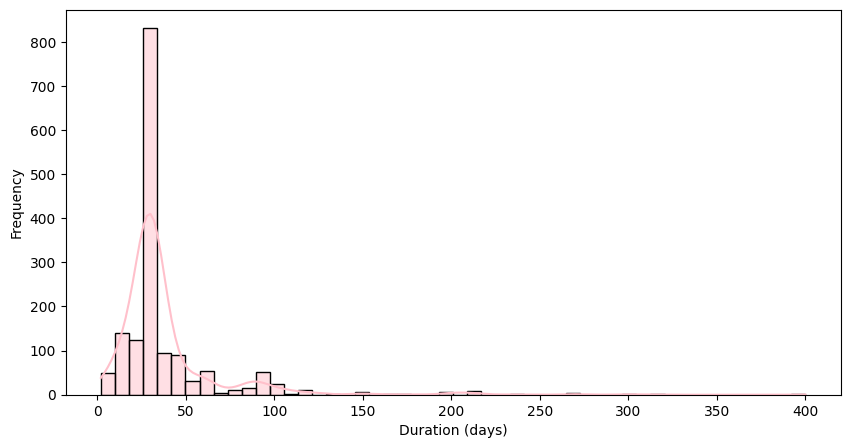

In [1777]:
plt.figure(figsize=(10, 5))
sns.histplot(data['DURATION'], bins=50, kde=True, color='pink')
plt.xlabel('Duration (days)')
plt.ylabel('Frequency')
plt.show()

The plot visualizes the distribution of prescription durations (`DURATION`) in days, with the x-axis representing duration and the y-axis showing frequency. Key observations include:

- The distribution is **right-skewed**, indicating most prescriptions have shorter durations (e.g., less than 100 days), with fewer prescriptions lasting longer.
- The peak frequency occurs at the lower end of the duration scale, suggesting a concentration of short-term prescriptions.
- The KDE curve reinforces the skewness, showing a gradual decline in probability density as duration increases.

### **Figure II: Medication Dosage Distribution per Day**

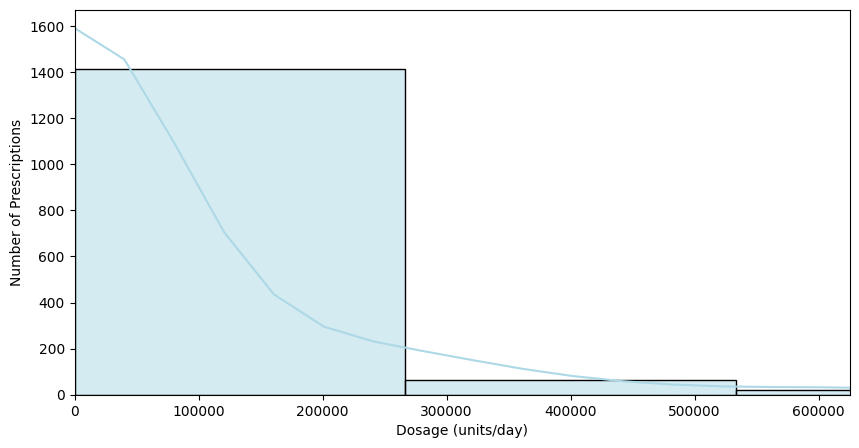

In [1778]:
plt.figure(figsize=(10, 5))
sns.histplot(data['PERDAY'], bins=30, kde=True, color='lightblue')
plt.xlabel('Dosage (units/day)')
plt.ylabel('Number of Prescriptions')
plt.xlim(0, data['PERDAY'].quantile(0.95))  # limited to 95th percentile for better visualization
plt.show()

The plot visualizes the distribution of daily medication dosages (`PERDAY`), with the x-axis representing dosage (units/day) and the y-axis showing the number of prescriptions. Key observations include:

- The distribution is **right-skewed**, indicating that most prescriptions have lower daily dosages, with fewer prescriptions requiring higher dosages.
- The x-axis is limited to the 95th percentile to improve visualization, focusing on the majority of the data.
- The peak frequency occurs at the lower end of the dosage scale, suggesting a concentration of prescriptions with lower daily dosages.

### **Figure III: Trends in Medication Prescriptions Over the Years**

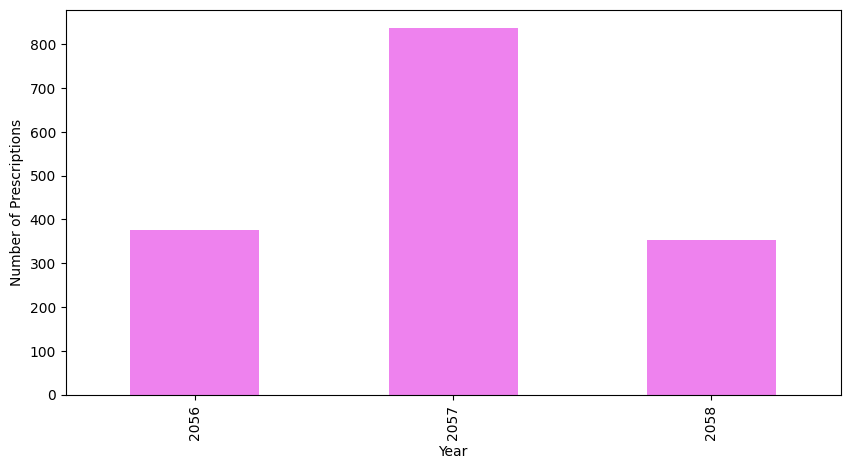

In [1779]:
data['DATE'] = pd.to_datetime(data['DATE'])
plt.figure(figsize=(10, 5))
data['DATE'].dt.year.value_counts().sort_index().plot(kind='bar', color='violet')
plt.xlabel('Year')
plt.ylabel('Number of Prescriptions')
plt.show()

This bar chart visualizes the annual trends in medication prescriptions, with the x-axis representing the year and the y-axis showing the number of prescriptions. Key observations include:

- The chart displays the count of prescriptions issued each year, allowing for a clear comparison of prescription volumes over time.
- It highlights whether prescription numbers are increasing, decreasing, or fluctuating annually, providing insights into healthcare utilization patterns.
- The y-axis ranges from 0 to 800, indicating the scale of prescription counts, while the x-axis lists the years under analysis.

### **Figure IV: Detailed Prescription Breakdown by Medication Category**

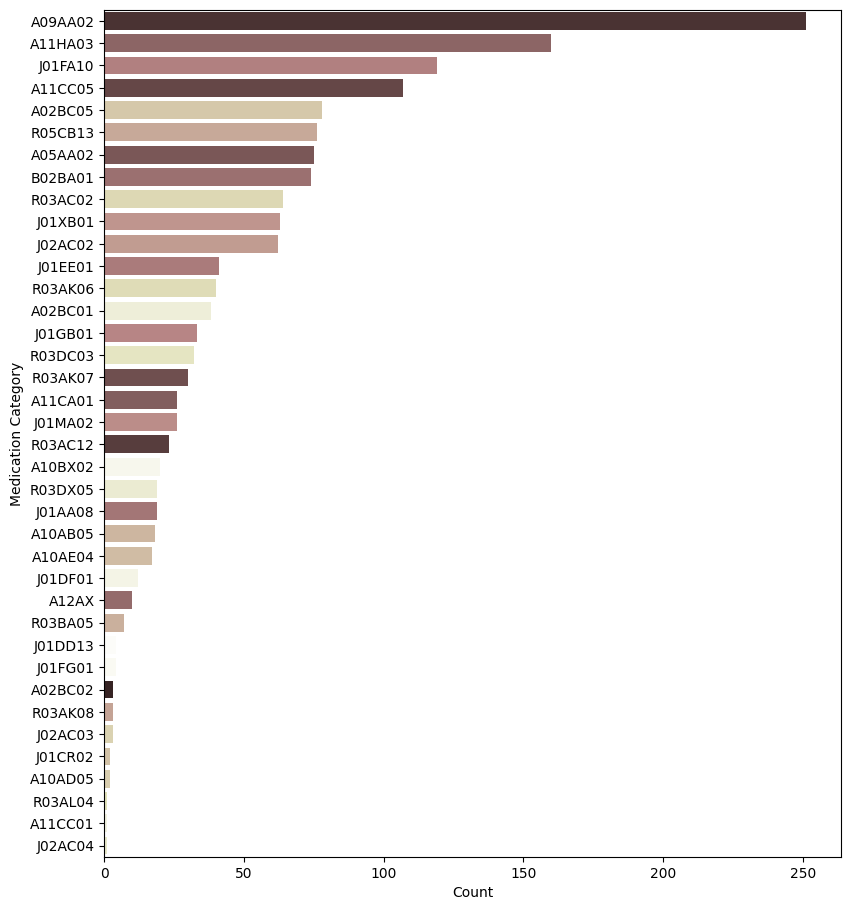

In [1780]:
plt.figure(figsize=(9.5, 11))
sns.countplot(y='CATEGORY', data=data, 
              order=data['CATEGORY'].value_counts().index, 
              hue='CATEGORY', palette='pink', legend=False)
plt.xlabel('Count')
plt.ylabel('Medication Category')
plt.show()

- The y-axis lists specific ATC codes (e.g., A09AA02, A11HA03), representing different medication categories.
- The x-axis shows the number of prescriptions for each category, ranging from 0 to 250.
- Categories are ordered by their prescription counts, with the most prescribed medications at the top.

The data reveals which medication categories are most frequently prescribed, providing a clear view of prescription patterns and helping identify trends in medication usage.

### **Figure V: Prescriptions per Main Medication Category**

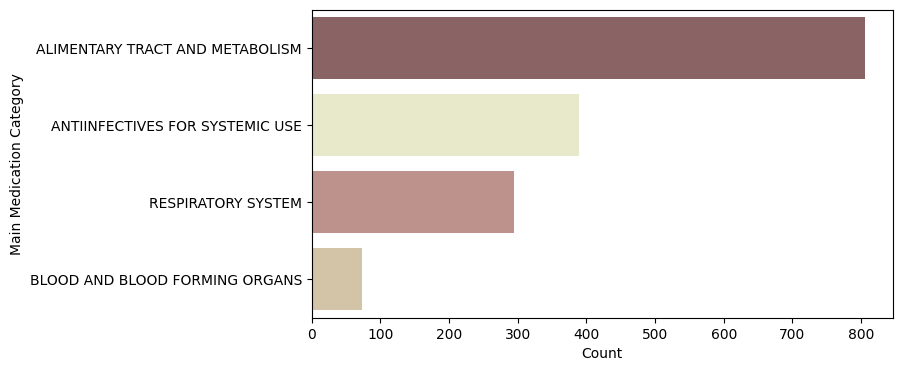

In [1781]:
plt.figure(figsize=(7.5, 4))
sns.countplot(y='CATEGORY_L1', data=data, 
              order=data['CATEGORY_L1'].value_counts().index, 
              hue='CATEGORY_L1', palette='pink', legend=False)
plt.xlabel('Count')
plt.ylabel('Main Medication Category')
plt.show()

- The y-axis lists high-level medication groups (e.g., Alimentary Tract and Metabolism, Antinfectives for Systemic Use, and etc.).
- The x-axis shows the number of prescriptions for each category, ranging from 0 to 800.
- Categories are ordered by their prescription counts, with the most prescribed groups at the top.

The data highlights the prevalence of prescriptions within each main medication category, providing a clear overview of which therapeutic areas are most commonly addressed in the dataset.

### **Figure VI: Prescriptions per Medication Subcategory**

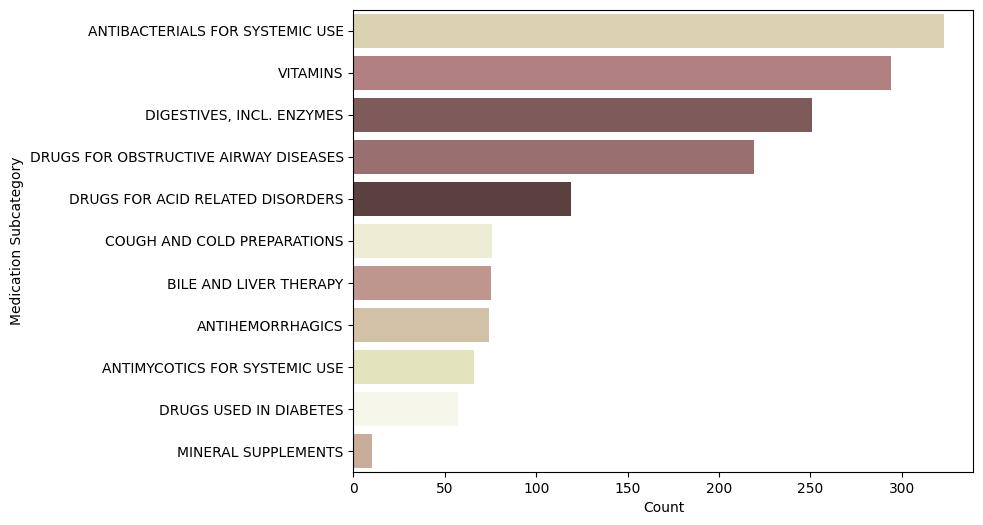

In [1782]:
plt.figure(figsize=(8, 6))
sns.countplot(y='CATEGORY_L2', data=data, 
              order=data['CATEGORY_L2'].value_counts().index, 
              hue='CATEGORY_L2', palette='pink', legend=False)
plt.xlabel('Count')
plt.ylabel('Medication Subcategory')
plt.show()

- The y-axis lists specific subcategories (e.g., Antibacterials for Systemic Use, Vitamins, Digestives, and etc.).
- The x-axis shows the number of prescriptions for each subcategory, ranging from 0 to 300.
- Subcategories are ordered by their prescription counts, with the most prescribed at the top.

The data provides a detailed view of prescription patterns within specific therapeutic subgroups, helping to identify which subcategories are most frequently prescribed.

### **Figure VII: Monthly Prescription Trends**

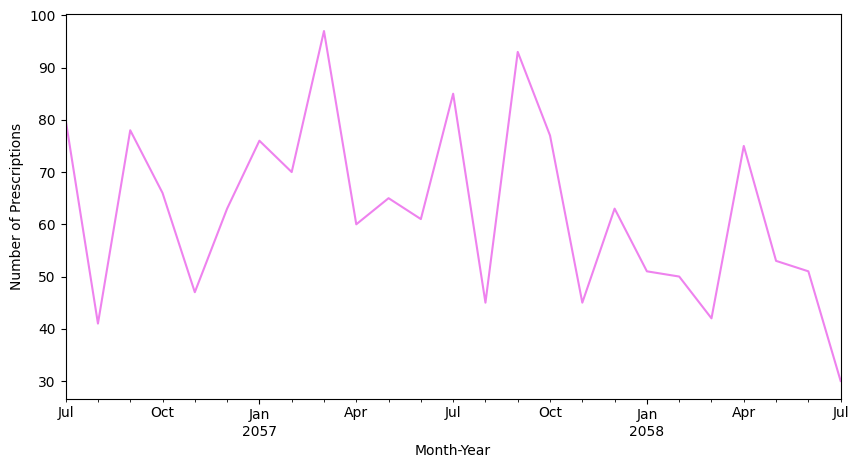

In [1783]:
data.set_index('DATE', inplace=True)

monthly_prescriptions = data.resample('ME').size()

plt.figure(figsize=(10,5))
monthly_prescriptions.plot(color='violet')
plt.xlabel('Month-Year')
plt.ylabel('Number of Prescriptions')
plt.show()

data.reset_index(inplace=True)

- The data shows noticeable fluctuations, suggesting potential seasonal trends in prescription volumes. For example:
     - Peaks in certain months (e.g., higher prescriptions in winter months) could indicate increased demand for medications due to seasonal illnesses.
     - Troughs in other months may reflect lower healthcare needs or reduced medication usage.
- The overall trend line reveals whether prescription counts are increasing, decreasing, or remaining stable over time.
   - For instance, a gradual upward trend might suggest growing healthcare needs or improved access to medications.

### **Figure VIII: Prescription Count Distribution per Patient**

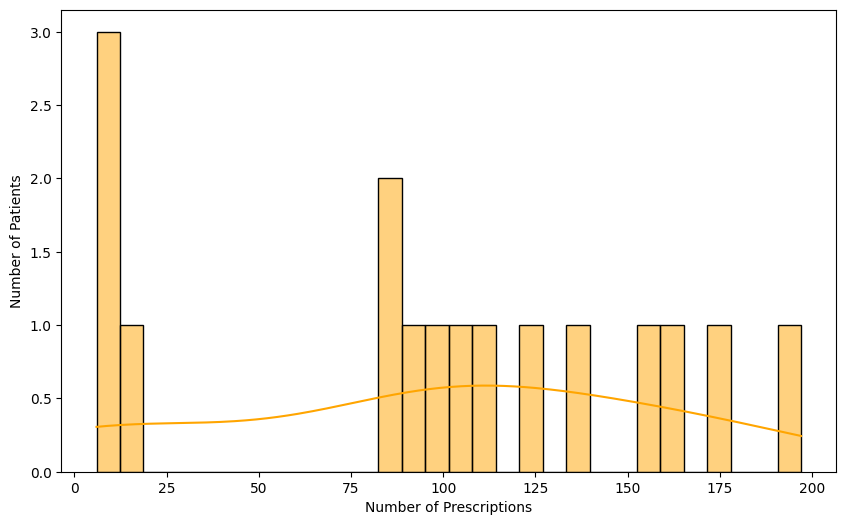

In [1784]:
patient_counts = data['PATIENT_ID'].value_counts()

plt.figure(figsize=(10,6))
sns.histplot(patient_counts, bins=30, kde=True, color='orange')
plt.xlabel('Number of Prescriptions')
plt.ylabel('Number of Patients')
plt.show()

- The data is **right-skewed**, indicating that most patients have a low number of prescriptions (e.g., fewer than 50), while a small subset has significantly higher counts (e.g., up to 200).
- The peak of the distribution shows the most common number of prescriptions per patient, which is likely in the lower range (e.g., 0–50).
- The long tail on the right highlights patients with unusually high prescription counts, which may warrant further investigation (e.g., chronic conditions or polypharmacy).

### **Figure IX: Correlation between Duration and Dosage per Day**

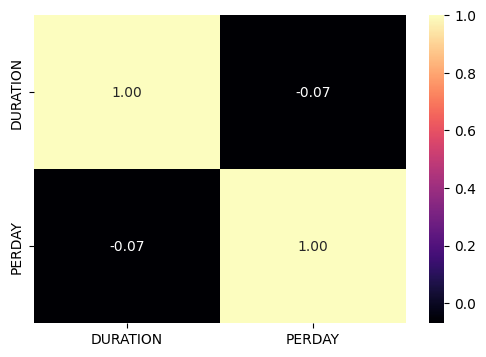

In [1785]:
corr_matrix = data[['DURATION', 'PERDAY']].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap='magma', fmt='.2f')
plt.show()

This figure shows a correlation heatmap between two variables: **Duration** and **Dosage per Day (PERDAY)**. The heatmap indicates:

- **Perfect positive correlation (1.00)** of each variable with itself, shown in light yellow along the diagonal.
- A very **weak negative correlation (-0.07)** between Duration and PERDAY, shown in black.
- The correlation matrix is **symmetrical**, showing the same -0.07 value in both off-diagonal positions.

The visualization suggests that there is almost no linear relationship between how long someone takes a medication (Duration) and the daily dosage amount (PERDAY). The code above the heatmap shows this was created using Python with **pandas** for correlation calculation and **seaborn** for the heatmap visualization.

Based on the analysis of the figure, we're looking at a correlation heatmap between Duration and Dosage per Day (PERDAY) variables. The data shows essentially no meaningful correlation (-0.07) between these two variables, indicating that the duration someone takes a medication appears to be independent of their daily dosage amount.

### **Figure X: Outlier Detection in Prescription Durations**

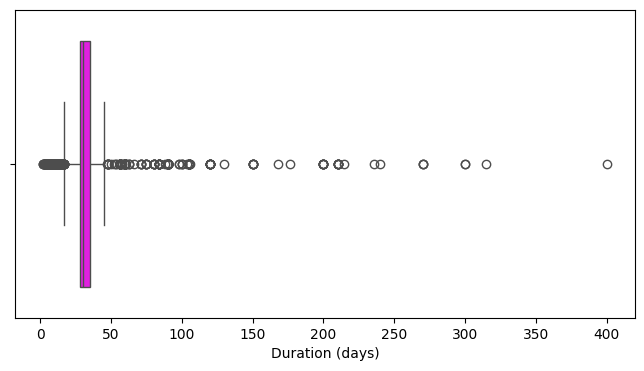

count    1564.000000
mean       38.339786
std        33.581154
min         2.000000
25%        28.000000
50%        30.000000
75%        35.377358
max       400.000000
Name: DURATION, dtype: float64

In [1786]:
plt.figure(figsize=(8,4))
sns.boxplot(x=data['DURATION'], color='magenta')
plt.xlabel('Duration (days)')
plt.show()

data['DURATION'].describe()

- The **vast majority of prescriptions** cluster around **30 days** (approximately one month), which is a common prescription duration.
- There are numerous **outliers extending to the right** (visible as individual circles), with some prescriptions extending to **400 days**.
- The **interquartile range (IQR)** (from 25th to 75th percentile) is relatively narrow (about **7.4 days**), indicating consistency in typical prescription durations.
- The **long right tail** suggests that while most prescriptions follow standard monthly protocols, there are cases requiring significantly longer treatment periods.

### **Figure XI: Outlier Detection for Dosage per Day**

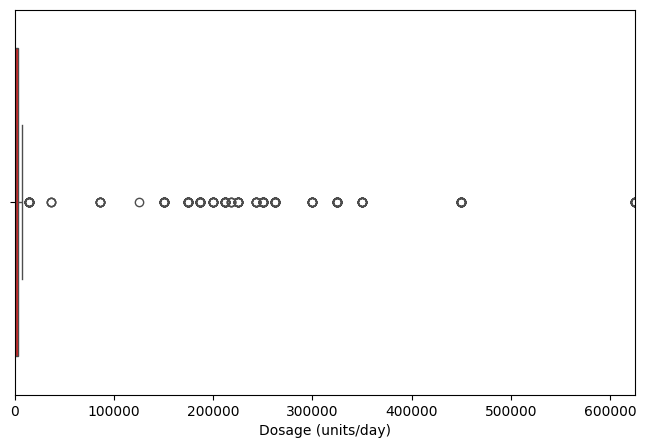

In [1787]:
# Outlier Detection for Dosage per Day
plt.figure(figsize=(8, 5))
sns.boxplot(x=data['PERDAY'], color='red')
plt.xlabel('Dosage (units/day)')
plt.xlim(0, data['PERDAY'].quantile(0.95))
plt.show()

- The visualization shows the distribution of **medication dosages** (units/day), with the **x-axis truncated at the 95th percentile** (approximately **600,000 units/day**) to focus on the main distribution pattern.
- There are significant **outliers on the lower end** of the dosage range that require further investigation, potentially indicating **data quality issues** or **unusual patient cases**.

### **Figure XII: Outlier Detection for Prescription Duration**

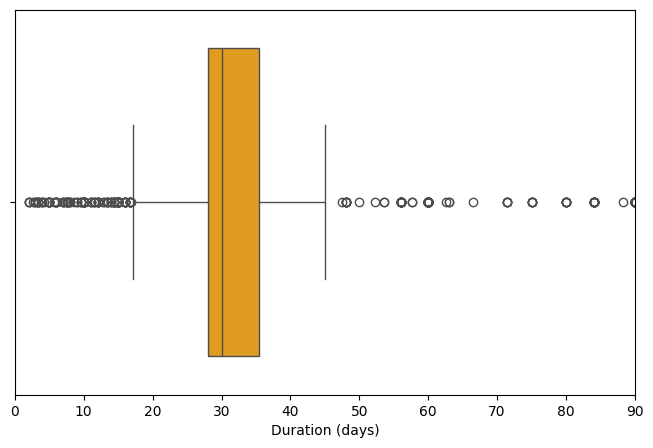

In [1788]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=data['DURATION'], color='orange')
plt.xlabel('Duration (days)')
plt.xlim(0, data['DURATION'].quantile(0.95))
plt.show()

- Most prescriptions last between **25-35 days** (the **interquartile range**).
- The **median duration** is approximately **30 days**.
- Several **outliers** exist beyond **50 days**, extending up to about **90 days**.
- The **x-axis** is limited to the **95th percentile** of the data distribution.

### **Sessa Empirical Estimation using K-Means Clustering Algorithm**

In [1789]:
def SEE_KMeans(atc: str, data=tidy) -> pd.DataFrame:
    df = data[data["ATC"] == atc].copy()

    drug_see_p0 = df.copy()
    drug_see_p1 = df.copy()

    drug_see_p1 = drug_see_p1.sort_values(by=["pnr", "eksd"])
    drug_see_p1["prev_eksd"] = drug_see_p1.groupby("pnr")["eksd"].shift(1)
    drug_see_p1 = drug_see_p1.dropna(subset=["prev_eksd"])

    drug_see_p1 = (
        drug_see_p1.groupby("pnr")
        .apply(lambda x: x.sample(1, random_state=SEED), include_groups=False)
        .reset_index()
    )
    drug_see_p1 = drug_see_p1[["pnr", "eksd", "prev_eksd"]]
    drug_see_p1["event.interval"] = (
        drug_see_p1["eksd"] - drug_see_p1["prev_eksd"]
    ).dt.days

    per = ecdf(drug_see_p1["event.interval"])
    x = per.cdf.quantiles
    y = per.cdf.probabilities

    dfper = pd.DataFrame({"x": x, "y": y})
    dfper = dfper[dfper["y"] <= 0.8]

    fig = plt.figure(figsize=(10, 8))
    gs = gridspec.GridSpec(2, 2)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(dfper["x"], dfper["y"], label="80% ECDF")
    ax1.set_title("80% ECDF")
    ax1.set_xlabel("Event interval")
    ax1.set_ylabel("Cumulative Probability")

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(x, y, label="100% ECDF")
    ax2.set_title("100% ECDF")
    ax2.set_xlabel("Event interval")
    ax2.set_ylabel("Cumulative Probability")

    ni = dfper["x"].max()
    drug_see_p2 = drug_see_p1[drug_see_p1["event.interval"] <= ni]

    d = np.log(drug_see_p2["event.interval"])

    ax3 = fig.add_subplot(gs[1, :])
    sns.kdeplot(d, label="Log(event interval)", fill=True, ax=ax3)
    ax3.set_title("Log(event interval)")
    ax3.set_xlabel("Log(event interval)")
    ax3.set_ylabel("Density")

    plt.tight_layout()
    plt.show()

    a = pd.DataFrame({"x": d, "y": d})
    a = (a - a.mean()) / a.std()

    silhouette_scores = []

    for n_clusters in range(2, 11):
        kmeans = KMeans(n_clusters=n_clusters, random_state=SEED)
        cluster_labels = kmeans.fit_predict(a)
        silhouette_avg = silhouette_score(a, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    max_cluster = np.argmax(silhouette_scores) + 2

    kmeans = KMeans(n_clusters=max_cluster, random_state=SEED)
    dfper["cluster"] = kmeans.fit_predict(dfper[["x"]])

    ni2 = dfper.groupby("cluster")["x"].min().reset_index()
    ni3 = dfper.groupby("cluster")["x"].max().reset_index()
    ni4 = dfper.groupby("cluster")["x"].median().reset_index()

    nif = pd.merge(ni2, ni3, on="cluster")
    nif = pd.merge(nif, ni4, on="cluster")
    nif.columns = ["Cluster", "Minimum", "Maximum", "Median"]
    nif["Median"] = np.exp(nif["Median"])

    results = (
        drug_see_p1.assign(key=1)
        .merge(nif.assign(key=1), on="key")
        .drop("key", axis=1)
    )
    results["Final_cluster"] = np.where(
        (results["event.interval"] >= results["Minimum"])
        & (results["event.interval"] <= results["Maximum"]),
        results["Cluster"],
        np.nan,
    )
    results = results.dropna(subset=["Final_cluster"])
    results = results.merge(
        dfper[["x", "y"]].rename(
            columns={
                "x": "event.interval",
                "y": "comulative.probability",
            }
        ),
        on="event.interval",
        how="left",
    )

    t1 = results["Cluster"].value_counts().idxmax()
    t1_merged = results[results["Cluster"] == t1].iloc[0]
    t1_merged = t1_merged[["Cluster", "Median"]]

    drug_see_p1 = pd.merge(
        drug_see_p1,
        results[["pnr", "Median", "Cluster", "comulative.probability"]],
        on="pnr",
        how="left",
    )
    drug_see_p1["Median"] = drug_see_p1["Median"].fillna(t1_merged["Median"])
    drug_see_p1["Cluster"] = drug_see_p1["Cluster"].fillna(0)
    drug_see_p1["test"] = drug_see_p1["event.interval"] - drug_see_p1["Median"]

    drug_see_p3 = drug_see_p1[
        [
            "pnr",
            "Median",
            "Cluster",
            "test",
            "event.interval",
            "comulative.probability",
        ]
    ]

    drug_see_p0 = pd.merge(drug_see_p0, drug_see_p3, on="pnr", how="left")
    drug_see_p0["Median"] = drug_see_p0["Median"].fillna(t1_merged["Median"])
    drug_see_p0["Cluster"] = drug_see_p0["Cluster"].fillna(0).astype(int)

    return drug_see_p0

### **Sessa Empirical Estimation using DBSCAN Clustering Algorithm**

In [1790]:
def SEE_DBSCAN(atc: str, data=tidy) -> pd.DataFrame:
    df = data[data["ATC"] == atc].copy()

    drug_see_p0 = df.copy()
    drug_see_p1 = df.copy()

    drug_see_p1 = drug_see_p1.sort_values(by=["pnr", "eksd"])
    drug_see_p1["prev_eksd"] = drug_see_p1.groupby("pnr")["eksd"].shift(1)
    drug_see_p1 = drug_see_p1.dropna(subset=["prev_eksd"])

    drug_see_p1 = (
        drug_see_p1.groupby("pnr")
        .apply(lambda x: x.sample(1, random_state=SEED), include_groups=False)
        .reset_index()
    )
    drug_see_p1 = drug_see_p1[["pnr", "eksd", "prev_eksd"]]
    drug_see_p1["event.interval"] = (
        drug_see_p1["eksd"] - drug_see_p1["prev_eksd"]
    ).dt.days

    per = ecdf(drug_see_p1["event.interval"])
    x = per.cdf.quantiles
    y = per.cdf.probabilities

    dfper = pd.DataFrame({"x": x, "y": y})
    dfper = dfper[dfper["y"] <= 0.8]

    fig = plt.figure(figsize=(10, 8))
    gs = gridspec.GridSpec(2, 2)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(dfper["x"], dfper["y"], label="80% ECDF")
    ax1.set_title("80% ECDF")
    ax1.set_xlabel("Event interval")
    ax1.set_ylabel("Cumulative Probability")

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(x, y, label="100% ECDF")
    ax2.set_title("100% ECDF")
    ax2.set_xlabel("Event interval")
    ax2.set_ylabel("Cumulative Probability")

    ni = dfper["x"].max()
    drug_see_p2 = drug_see_p1[drug_see_p1["event.interval"] <= ni]

    d = np.log(drug_see_p2["event.interval"])

    ax3 = fig.add_subplot(gs[1, :])
    sns.kdeplot(d, label="Log(event interval)", fill=True, ax=ax3)
    ax3.set_title("Log(event interval)")
    ax3.set_xlabel("Log(event interval)")
    ax3.set_ylabel("Density")

    plt.tight_layout()
    plt.show()

    best_score = -1
    best_eps = 0.5

    for eps in np.arange(0.5, 5.0, 0.1):
        cluster_labels = DBSCAN(eps).fit_predict(dfper[["x"]])

        if len(set(cluster_labels)) < 2:
            continue

        score = silhouette_score(dfper[["x"]], cluster_labels)

        if score > best_score:
            best_score = score
            best_eps = eps

    dfper["cluster"] = DBSCAN(best_eps).fit_predict(dfper[["x"]])

    ni2 = dfper.groupby("cluster")["x"].min().reset_index()
    ni3 = dfper.groupby("cluster")["x"].max().reset_index()
    ni4 = dfper.groupby("cluster")["x"].median().reset_index()

    nif = pd.merge(ni2, ni3, on="cluster")
    nif = pd.merge(nif, ni4, on="cluster")
    nif.columns = ["Cluster", "Minimum", "Maximum", "Median"]
    nif["Median"] = np.exp(nif["Median"])

    results = (
        drug_see_p1.assign(key=1)
        .merge(nif.assign(key=1), on="key")
        .drop("key", axis=1)
    )
    results["Final_cluster"] = np.where(
        (results["event.interval"] >= results["Minimum"])
        & (results["event.interval"] <= results["Maximum"]),
        results["Cluster"],
        np.nan,
    )
    results = results.dropna(subset=["Final_cluster"])
    results = results.merge(
        dfper[["x", "y"]].rename(
            columns={
                "x": "event.interval",
                "y": "comulative.probability",
            }
        ),
        on="event.interval",
        how="left",
    )

    if results.empty:
        print("Warning: No valid clusters found.")
        return pd.DataFrame()

    t1 = results["Cluster"].value_counts().idxmax()
    t1_merged = results[results["Cluster"] == t1].iloc[0]
    t1_merged = t1_merged[["Cluster", "Median"]]

    drug_see_p1 = pd.merge(
        drug_see_p1,
        results[["pnr", "Median", "Cluster", "comulative.probability"]],
        on="pnr",
        how="left",
    )
    drug_see_p1["Median"] = drug_see_p1["Median"].fillna(t1_merged["Median"])
    drug_see_p1["Cluster"] = drug_see_p1["Cluster"].fillna(0)
    drug_see_p1["test"] = drug_see_p1["event.interval"] - drug_see_p1["Median"]

    drug_see_p3 = drug_see_p1[
        [
            "pnr",
            "Median",
            "Cluster",
            "test",
            "event.interval",
            "comulative.probability",
        ]
    ]

    drug_see_p0 = pd.merge(drug_see_p0, drug_see_p3, on="pnr", how="left")
    drug_see_p0["Median"] = drug_see_p0["Median"].fillna(t1_merged["Median"])
    drug_see_p0["Cluster"] = drug_see_p0["Cluster"].fillna(0).astype(int)

    return drug_see_p0

### **Sessa Empirical Assumption**

In [1791]:
def SEE_assumption(data: pd.DataFrame) -> None:
    data = data.sort_values(by=["pnr", "eksd"])
    data["prev_eksd"] = data.groupby("pnr")["eksd"].shift(1)

    drug_see2 = data[data["prev_eksd"].notna()]
    drug_see2["p_number"] = drug_see2.groupby("pnr").cumcount() + 1
    drug_see2 = drug_see2[drug_see2["p_number"] >= 2]
    drug_see2 = drug_see2[["pnr", "eksd", "prev_eksd", "p_number"]]
    drug_see2["Duration"] = (
        drug_see2["eksd"] - drug_see2["prev_eksd"]
    ).dt.days
    drug_see2["p_number"] = drug_see2["p_number"].astype("category")

    medians_of_medians = (
        drug_see2.groupby("pnr")["Duration"].median().reset_index()
    )

    plt.figure(figsize=(10, 6))
    sns.boxplot(x="p_number", y="Duration", data=drug_see2)
    plt.axhline(
        y=medians_of_medians["Duration"].median(), color="r", linestyle="--"
    )
    plt.title("Duration by Prescription Number")
    plt.show()

In [1792]:
def SEE_clustering_plot(data: pd.DataFrame, clustering: str) -> None:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x="event.interval",
        y="comulative.probability",
        hue="Cluster",
        data=data,
        palette="viridis",
    )
    plt.title(f"80% ECDF {clustering} Clustering")
    plt.xlabel("Event Interval")
    plt.ylabel("Cumulative Probability")
    plt.show()


## **Data Analysis**

#### *Sessa Empirical Estimator using K Means*

#### A. ATC = medA

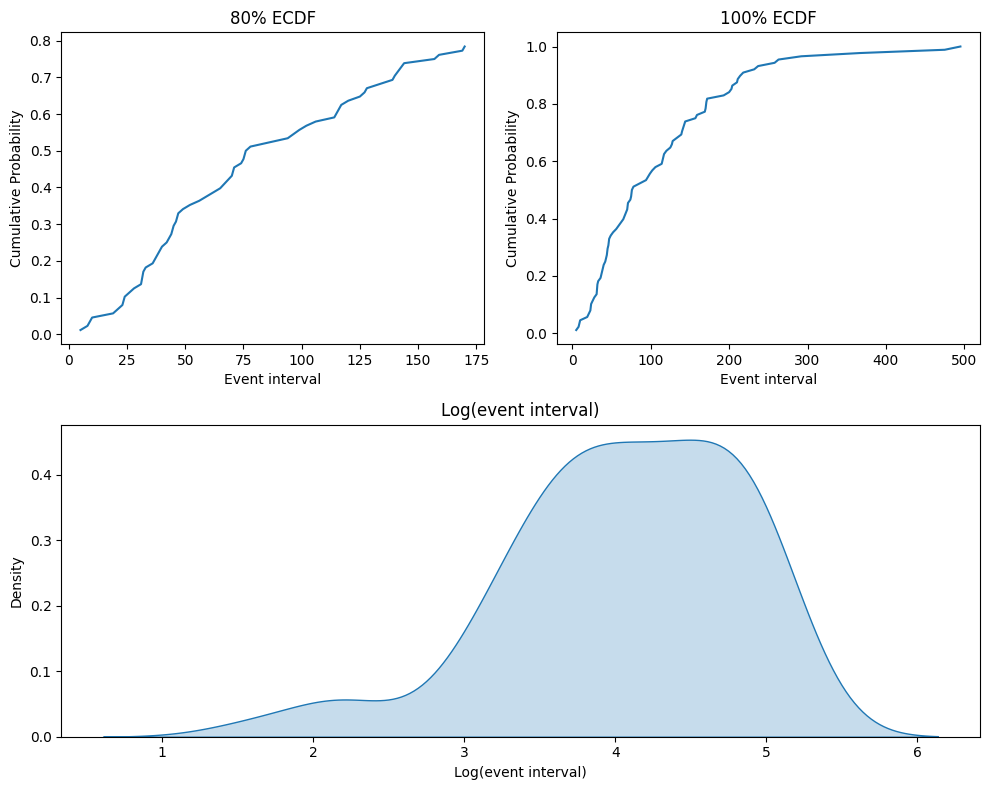

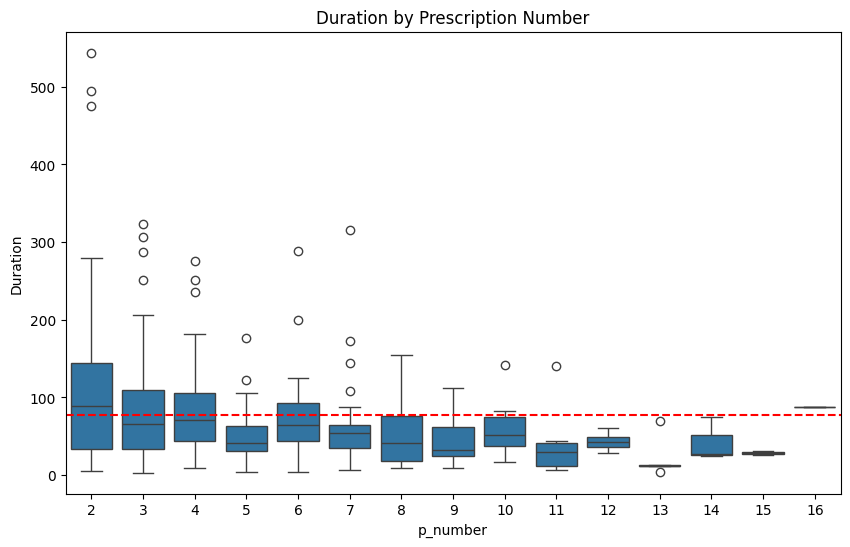

In [ ]:
med_a_kmeans = SEE_KMeans("medA")

SEE_assumption(med_a_kmeans)

#### B. ATC = medB

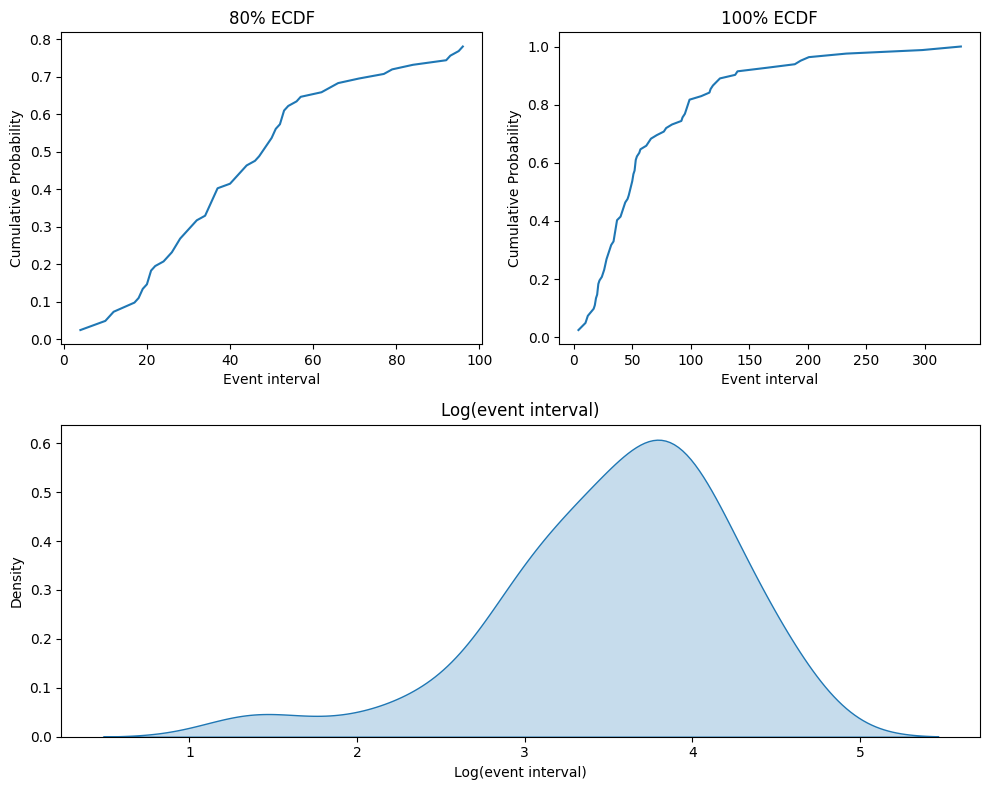

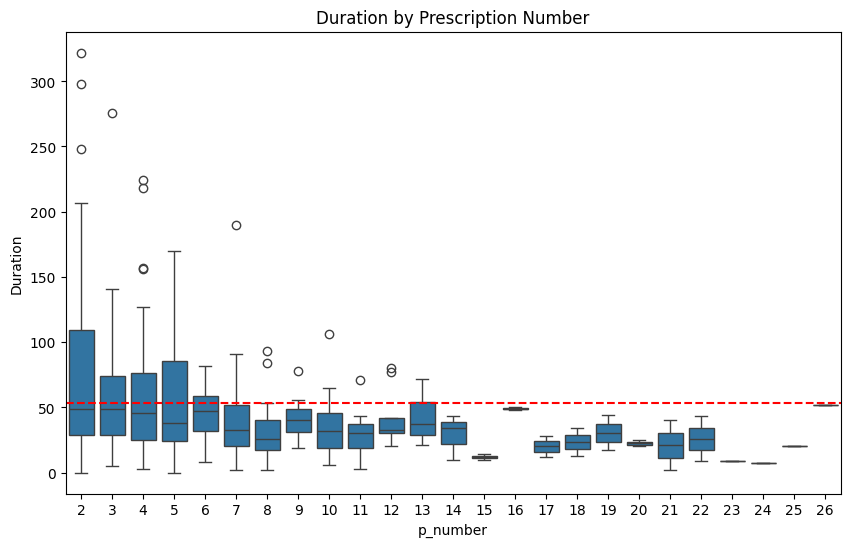

In [ ]:
med_b_kmeans = SEE_KMeans("medB")

SEE_assumption(med_b_kmeans)

#### *Sessa Empirical Estimator using DBSCAN*

#### A. ATC = medA

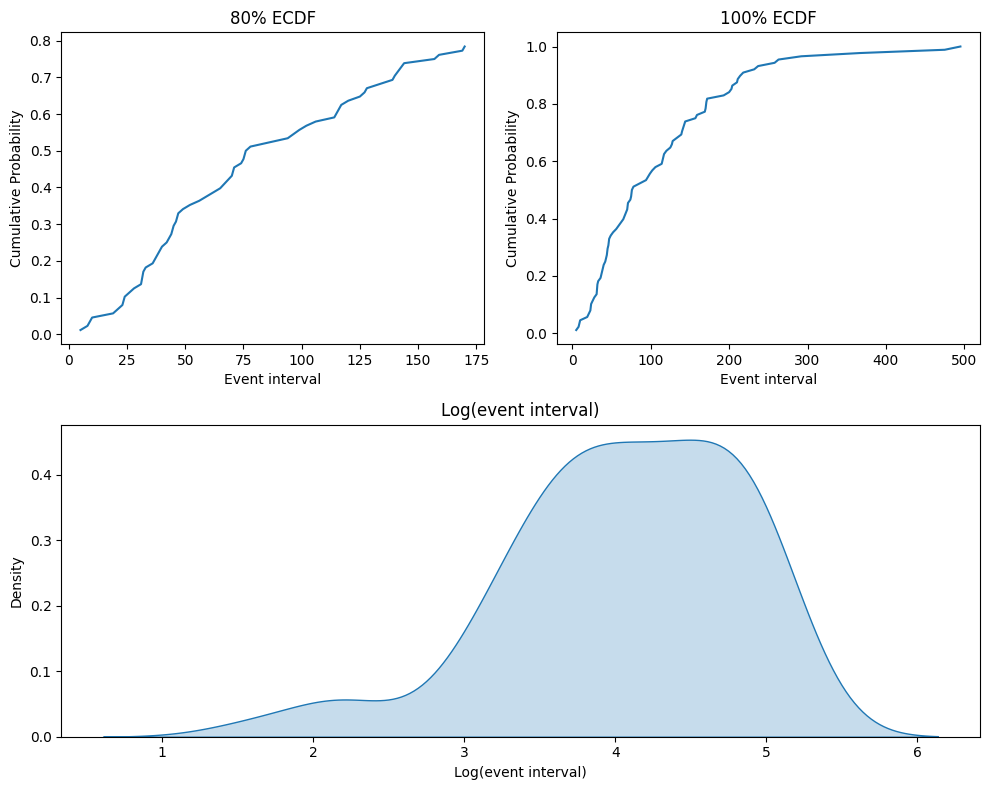

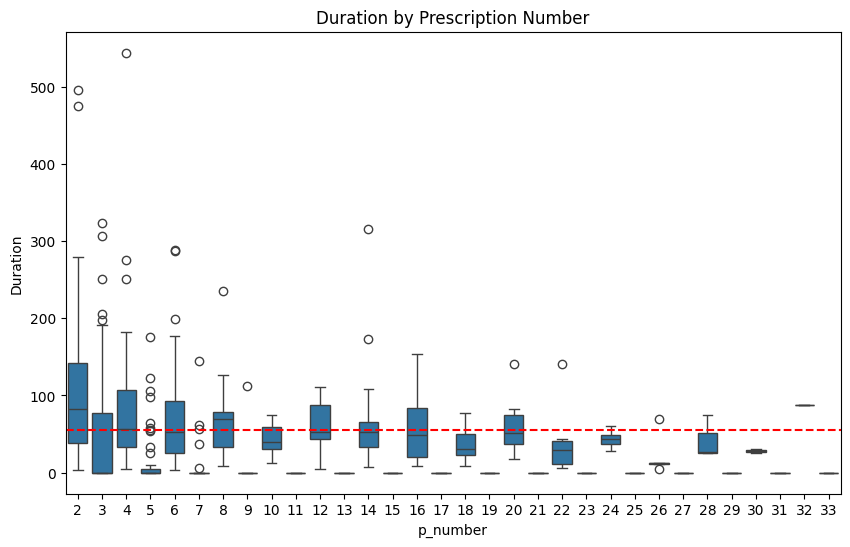

In [ ]:
med_a_dbscan = SEE_DBSCAN("medA")

SEE_assumption(med_a_dbscan)

#### B. ATC = medB

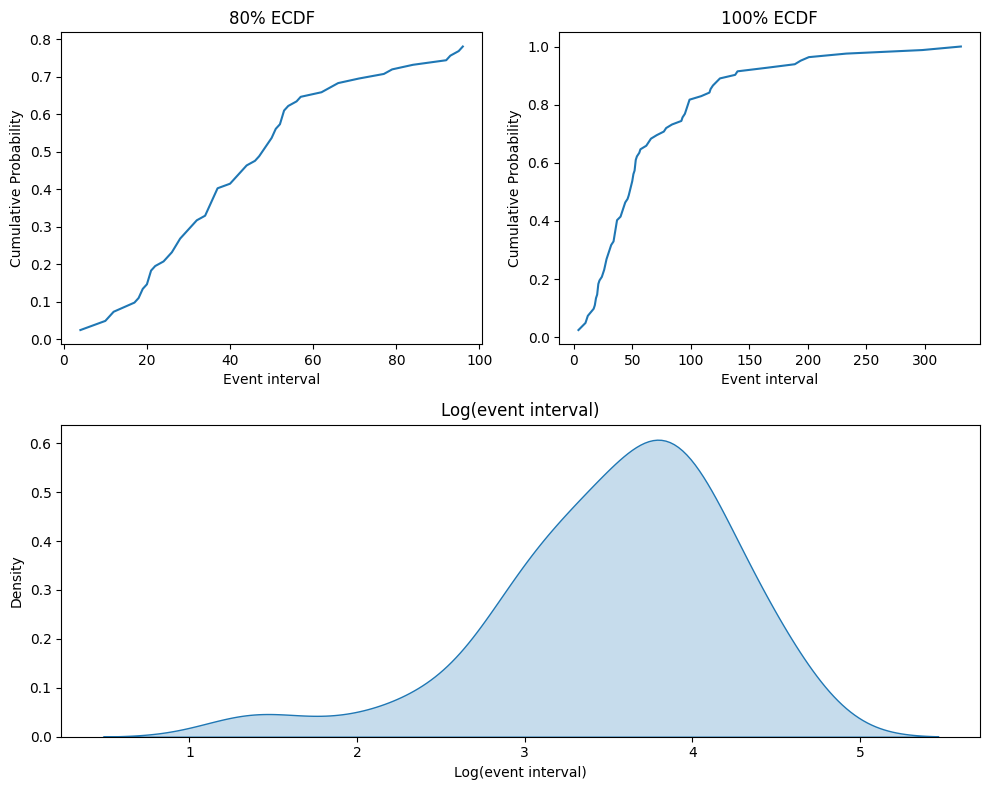

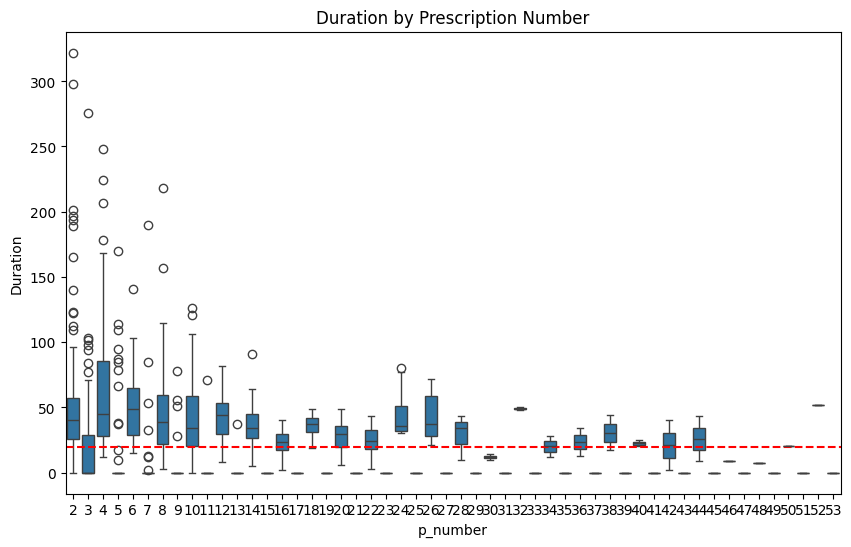

In [ ]:
med_b_dbscan = SEE_DBSCAN("medB")

SEE_assumption(med_b_dbscan)

#### *Comparison of Clustering Methods*

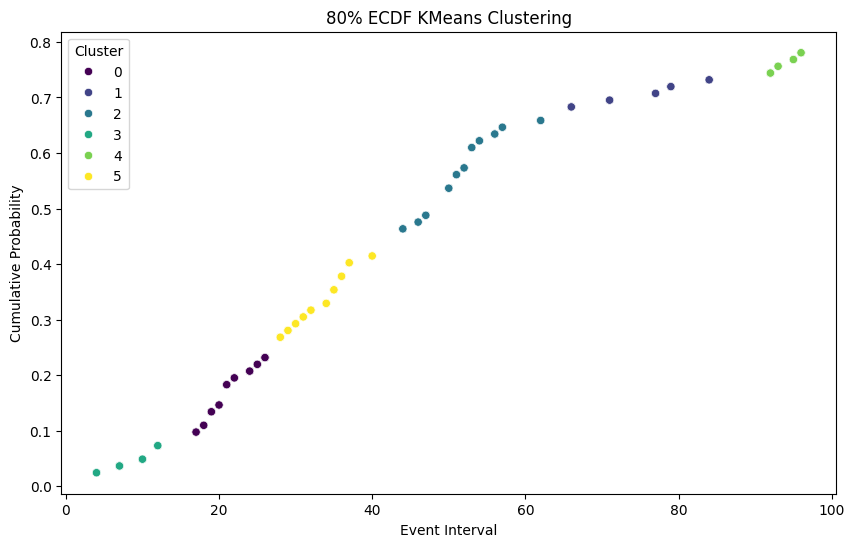

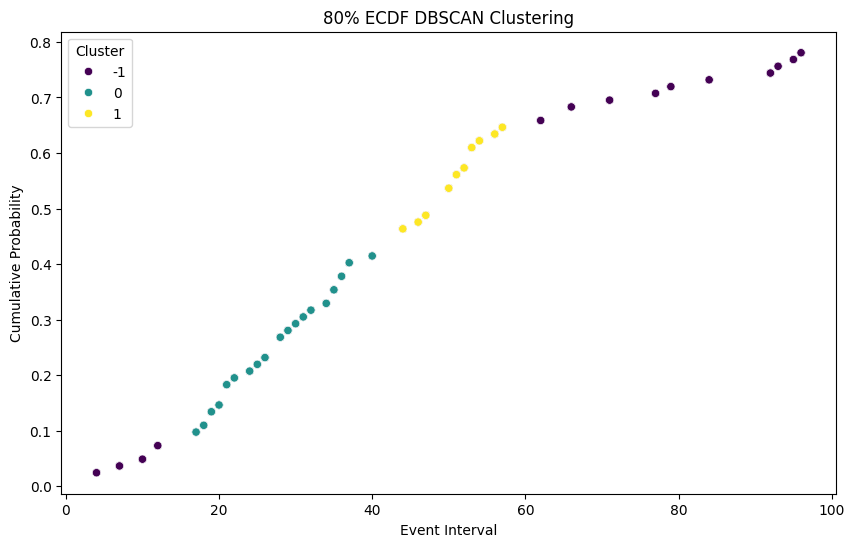

In [ ]:
SEE_clustering_plot(med_b_kmeans, "KMeans")
SEE_clustering_plot(med_b_dbscan, "DBSCAN")


## **Results and Discussion**

### **Observations From the SEE + KMeans Plots**

#### **A. Early Prescriptions Have Greater Variability**
- In both medication groups, early prescriptions (e.g., p_number 2, 3, 4) exhibit:
  - Large spreads in Duration values.
  - Outliers reaching up to ~500 days for some patients.
  - High variability, possibly due to patients still adjusting to their medication schedules.

#### **B. Convergence in Later Prescriptions**
- As prescription numbers increase (e.g., beyond 10–15), refill intervals stabilize:
  - The spread of durations narrows.
  - Fewer extreme outliers.
  - Indicates that patients tend to adopt regular refill intervals over time.

#### **C. Differences Between Medication Groups**
- **Number of Prescriptions:**
  - Some medications have more total refills, indicating either longer treatments or more frequent dosing.
- **Overall Duration Range:**
  - Some groups show early outliers up to ~500 days but later stabilize to ~50–100 days.
- **Median Refill Duration:**
  - One group exhibits shorter refill intervals (~30–40 days), while another stabilizes at ~50–60 days.

### **Observations From the SEE + DBSCAN Plots**

#### **A. Early Prescriptions Have Greater Variability**
- Similar to KMeans, early prescriptions display wide duration ranges and outliers.
- Patients may still be establishing their adherence patterns.

#### **B. Convergence in Later Prescriptions**
- After a certain prescription count (e.g., beyond 10–15), refill intervals stabilize.
- Boxplots become narrower, indicating more predictable adherence.

#### **C. Differences Between Medication Groups**
- **DBSCAN detects more nuanced refill behaviors:**
  - More clusters found compared to KMeans, indicating variability within stable regimens.
  - Some extreme refill behaviors are categorized as noise rather than included in clusters.

### **Comparison: SEE + KMeans vs. SEE + DBSCAN**

| Aspect                  | KMeans                                      | DBSCAN                                      |
|-------------------------|---------------------------------------------|---------------------------------------------|
| **Early Variability**   | High; all points forced into clusters       | High, but extreme values classified as noise |
| **Convergence Over Time** | Later refills stabilize (~50–100 days)      | Similar stabilization (~50–100 days)        |
| **Outlier Handling**    | Included in clusters                        | Marked as noise, improving pattern clarity |
| **Cluster Count**       | Fixed number                                | Varies based on density                     |
| **Best For**            | General trend analysis                     | Detailed segmentation and outlier detection |

### **Key Insights & Implications**
- **Early Refill Irregularity:** Both methods confirm high variability in the first few prescriptions.
- **Stabilization Over Time:** Later refill intervals become predictable.
- **Different Refill Patterns:** DBSCAN provides a more nuanced view of adherence patterns.
- **Clinical & Operational Implications:**
  - Identifying non-adherence early.
  - Forecasting medication demand.
  - Designing tailored interventions for at-risk patients.




## **Conclusion**

This study implemented the Sessa Empirical Estimator (SEE) with K-Means and DBSCAN to analyze medication refill patterns. Key findings include:
- **Early refill variability is high**, indicating patient adjustment periods.
- **Refill intervals stabilize over time**, suggesting adherence improves with routine.
- **KMeans provides a structured, general overview**, useful for summarizing trends.
- **DBSCAN isolates outliers as noise**, making it more effective for detailed adherence analysis.

### **Practical Applications**
- **Healthcare Providers** can use clustering insights to identify non-adherent patients early.
- **Pharmacies** can optimize inventory by predicting demand based on refill behavior.
- **Researchers** can refine models to further improve medication adherence analysis.

Future work can explore hybrid clustering approaches and validation techniques to enhance pattern recognition in refill behaviors.

